In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from ipywidgets import interact, Dropdown

**This Python code conducts a component - level in - depth analysis of an HVAC system. It 
analyzes three key aspects: RTU components, where it calculates energy distribution and 
presents it in a pie chart and bar plot; compressors, comparing their runtime and simultaneous
 operation with a stacked area plot; and VAV terminals, evaluating airflow efficiency and 
 temperature control. Results include performance metrics and interactive visualizations for 
 each component.**

In [28]:
# 1. RTU Subsystem Analysis
def analyze_rtu_components(df):
    """Energy breakdown of RTU components"""
    # Energy consumption calculation
    components = ['WH_RTU_Comp1', 'WH_RTU_Comp2', 
                 'WH_RTU_Cond1', 'WH_RTU_Cond2',
                 'WH_RTU_Sup_Fan']
    
    component_energy = df[components].sum()
    total_energy = df['WH_RTU_Total'].sum()
    component_ratio = (component_energy / total_energy * 100).round(1)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie chart
    ax1.pie(component_ratio, 
            labels=[f'{n}\n({p}%)' for n,p in zip(component_ratio.index, component_ratio)],
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('pastel'))
    ax1.set_title('RTU Energy Distribution')
    
    # Bar plot
    sns.barplot(x=component_ratio.index, y=component_ratio, ax=ax2, palette='Blues_d')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Component Energy Contribution')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return component_ratio

In [29]:
# 2. Compressor Efficiency Analysis
def analyze_compressors(df):
    """Comparative analysis of compressors"""
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df = df.set_index('TIMESTAMP')
    # Runtime comparison
    comp1_runtime = (df['WH_RTU_Comp1'] > 0).sum()
    comp2_runtime = (df['WH_RTU_Comp2'] > 0).sum()
    
    # Simultaneous operation
    dual_run = (df['WH_RTU_Comp1'] > 0) & (df['WH_RTU_Comp2'] > 0)
    dual_run_percentage = dual_run.mean() * 100
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Stacked area plot
    df[['WH_RTU_Comp1', 'WH_RTU_Comp2']].resample('D').sum().plot.area(
        ax=ax, alpha=0.7, color=['#1f77b4', '#ff7f0e'])
    
    ax.set_title(f'Compressor Operation\nDual-run: {dual_run_percentage:.1f}% of time')
    ax.set_ylabel('Daily Energy Consumption (Wh)')
    ax.legend(['Compressor 1', 'Compressor 2'])
    
    plt.show()
    
    return {
        'comp1_runtime': comp1_runtime,
        'comp2_runtime': comp2_runtime,
        'dual_run_percentage': dual_run_percentage
    }

In [30]:
# 3. VAV Terminal Analysis
def analyze_vav_performance(df):
    """VAV terminal unit performance evaluation"""
    # Find all VAVs present in data
    vav_list = [col.split('_')[-1] for col in df.columns 
               if col.startswith('AF_VAV_')]
    
    # Airflow efficiency calculation
    for vav in vav_list:
        df[f'VAV_{vav}_efficiency'] = (df[f'AF_VAV_{vav}'] / df['AF_RTU']) * 100
    
    # Temperature control analysis
    temp_diffs = []
    for vav in vav_list:
        room_col = f'T_Room_{vav}'
        vav_col = f'T_VAV_{vav}'
        if room_col in df.columns and vav_col in df.columns:
            df[f'Room_{vav}_temp_diff'] = df[room_col] - df[vav_col]
            temp_diffs.append(df[f'Room_{vav}_temp_diff'].std())
        else:
            temp_diffs.append(np.nan)
    
    # Create summary DataFrame
    vav_stats = pd.DataFrame({
        'VAV_ID': vav_list,
        'Avg_Flow_Efficiency': [df[f'VAV_{vav}_efficiency'].mean() for vav in vav_list],
        'Temp_Control_STD': temp_diffs
    }).set_index('VAV_ID')
    
    # Interactive visualization
    def plot_vav(vav_id):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Airflow efficiency
        df[f'VAV_{vav_id}_efficiency'].plot(ax=ax1, alpha=0.7)
        ax1.axhline(y=vav_stats.loc[vav_id, 'Avg_Flow_Efficiency'], 
                   color='r', linestyle='--')
        ax1.set_title(f'VAV {vav_id} Airflow Efficiency\n(Mean: {vav_stats.loc[vav_id, "Avg_Flow_Efficiency"]:.1f}%)')
        ax1.set_ylabel('Efficiency (%)')
        
        # Temperature control
        if f'Room_{vav_id}_temp_diff' in df.columns:
            df[f'Room_{vav_id}_temp_diff'].plot(ax=ax2, color='green', alpha=0.7)
            ax2.axhline(y=0, color='k', linestyle=':')
            ax2.set_title(f'Room {vav_id} Temperature Deviation\n(STD: {vav_stats.loc[vav_id, "Temp_Control_STD"]:.2f}°C)')
            ax2.set_ylabel('ΔT (°C)')
        
        plt.tight_layout()
        plt.show()
    
    # Display interactive selector
    interact(plot_vav, vav_id=Dropdown(options=vav_list))
    
    return vav_stats.sort_values('Temp_Control_STD', ascending=False)

RTU Component Analysis


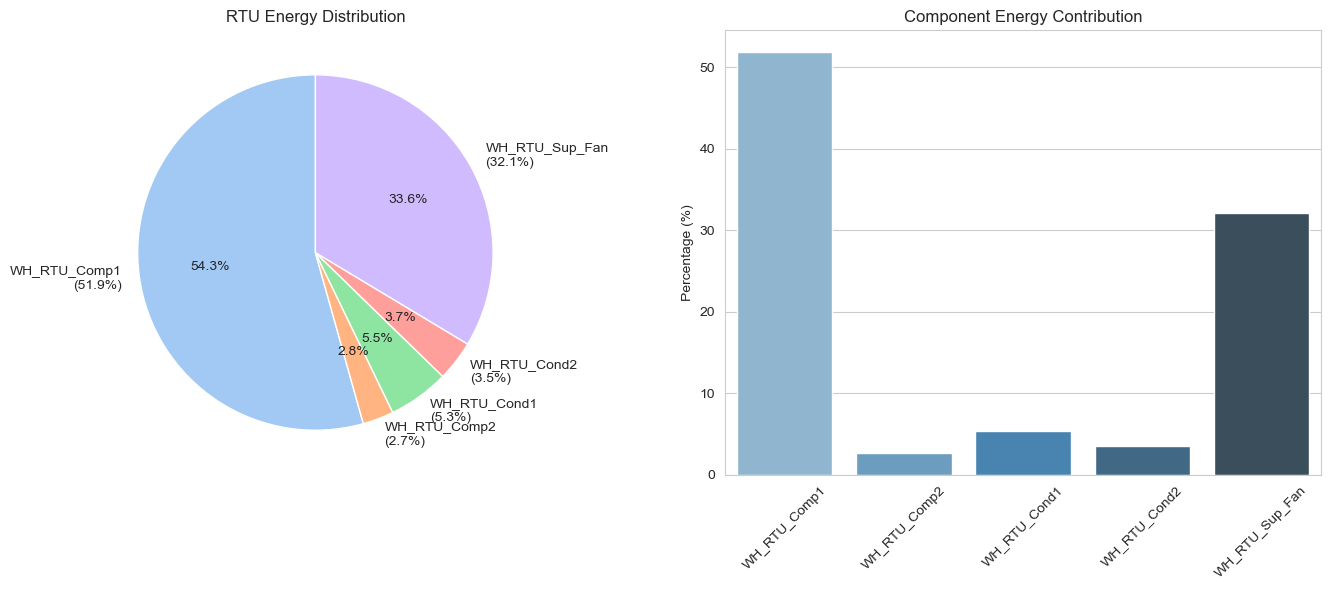


Compressor Performance


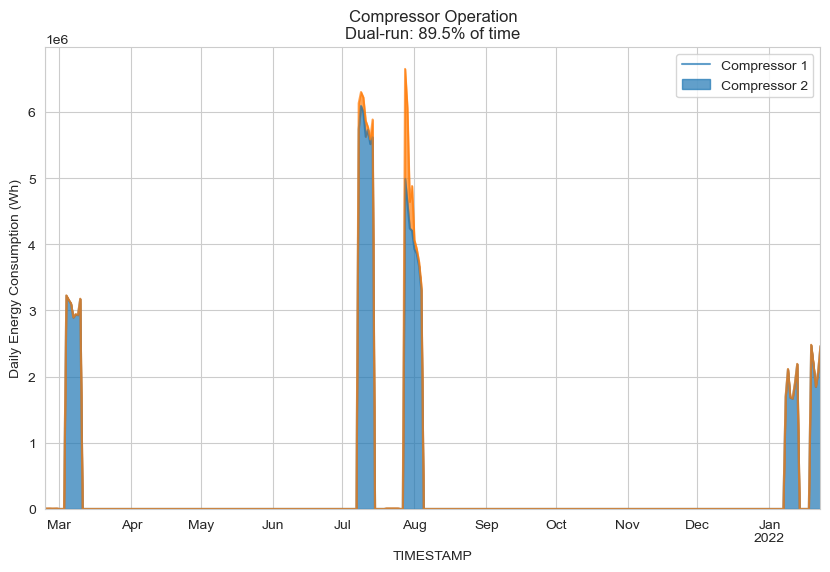


VAV Terminal Analysis


interactive(children=(Dropdown(description='vav_id', options=('102', '103', '104', '105', '106', '202', '203',…

Display worst performing VAVs


,Avg_Flow_Efficiency,Temp_Control_STD
VAV_ID,,
102,3.676428,8.526661
106,9.779971,7.220525
104,10.045901,5.856038
204,11.098818,5.600872
203,4.821945,5.442395


In [31]:
# Load your dataframe here
df = pd.read_csv('../../outputs/HVAC_cleaned_data.csv', parse_dates=['TIMESTAMP'])
# print(df.dtypes)
    
# Example usage (with test data)
print("RTU Component Analysis")
component_results = analyze_rtu_components(df)
    
print("\nCompressor Performance")
compressor_results = analyze_compressors(df)
    
print("\nVAV Terminal Analysis")
vav_results = analyze_vav_performance(df)
    
# Display worst performing VAVs
print('Display worst performing VAVs')
display(vav_results.head(5).style.background_gradient(cmap='Reds'))